# A. Import libraries and set up parameter

### 1. Import Lib

In [4]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, ConcatDataset
import time
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import joblib

### 2. Parameter

In [5]:
WINDOW_SIZE = 11 # 10 PERIODS OF TIME FOR VARIABLE X + 1 PERIOD FOR Y
INPUT_DIM = 50 # 5 ATTRIBUTES * 10 PERIODS OF TIME X
OUTPUT_DIM = 1 # THE FUTURE CLOSE PRICE
NUM_LAYERS = 4
HIDDEN_DIM = 64

# ====================================
# DATA PATH
DATA_DIR = "./data/"
DATA_FPT_PATH = DATA_DIR+"FPT.csv"
DATA_MSN_PATH = DATA_DIR+"MSN.csv"
DATA_PNJ_PATH = DATA_DIR+"PNJ.csv"
DATA_VIC_PATH = DATA_DIR+"VIC.csv"

# ====================================
# SAVE MODELS
MODEL_DIR = "./results/"

#=====================================
# TRAINING
BATCH_SIZE = 128
EPOCHS = 100
LEARNING_RATE = 0.02

# =====================================
# DEVICE CONFIGURATION
import torch
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# B. Prepare Data

### 1. Preprocess data

In [6]:
df_FPT = pd.read_csv(DATA_FPT_PATH)
df_MSN = pd.read_csv(DATA_MSN_PATH)
df_PNJ = pd.read_csv(DATA_PNJ_PATH)
df_VIC = pd.read_csv(DATA_VIC_PATH)

def process_date_time(df):
    # Convert 'Date/Time' to datetime format
    df['Date/Time'] = pd.to_datetime(df['Date/Time'])

    # Rename 'Date/Time' to 'Minus' and format it
    df['Minus'] = df['Date/Time'].dt.strftime('%Y%m%d%H%M')

    # Extract 'Hours' and 'Days'
    df["Hours"] = df['Date/Time'].dt.strftime('%Y%m%d%H')
    df["Days"] = df['Date/Time'].dt.strftime('%Y%m%d')

    # Reorder columns
    df = df[['Minus', 'Hours', 'Days', 'Open', 'High', 'Low', 'Close', 'Volume', 'Ticker', 'Open Interest']]
    # Sort DataFrame by 'Minus', 'Ticker'
    df = df.sort_values(['Minus', 'Ticker'], ascending = [True, True])

    return df

def groupby_hours_df(df):
    df.set_index('Hours', inplace=True) 
    df = df.groupby(df.index)[['Open', 'High', 'Low', 'Close', 'Volume']].mean()
    return df

df_FPT = process_date_time(df_FPT)
df_MSN = process_date_time(df_MSN)
df_PNJ = process_date_time(df_PNJ)
df_VIC = process_date_time(df_VIC)

df_FPT = groupby_hours_df(df_FPT)
df_MSN = groupby_hours_df(df_MSN)
df_PNJ = groupby_hours_df(df_PNJ)
df_VIC = groupby_hours_df(df_VIC)

In [7]:
df_FPT

,Open,High,Low,Close,Volume
Hours,,,,,
2018122509,30.760000,30.781429,30.744286,30.760000,12137.142857
2018122609,31.055714,31.065357,31.047500,31.057143,1783.928571
2018122610,31.121842,31.125789,31.116579,31.121579,2508.684211
2018122611,31.036875,31.046250,31.034375,31.046250,2331.250000
2018122613,30.993200,31.002800,30.993200,31.002800,2451.200000
...,...,...,...,...,...
2020122209,57.468889,57.486667,57.440000,57.453333,7560.888889
2020122210,57.393333,57.413333,57.368333,57.393333,5966.833333
2020122211,57.507143,57.532143,57.471429,57.507143,12836.428571


### 2. Dataset Class

In [8]:
class TrainingDataset(Dataset):
    def __init__(self, df, window_size=11):
        self.data = df
        self.seq_len  = window_size
        self.index = self.data.index.unique()
    
    def __len__(self):
        return len(self.index)-1
    
    def __getitem__(self, idx_time):
        d_x = idx_time - self.seq_len + 1
        d_y = idx_time
        X = self.data.loc[self.index[d_x:idx_time]]
        if X.empty:
            X = np.zeros((1, (self.seq_len-1)*5)).reshape(1,-1)
            return X , np.array([0])
        
        data_y = self.data.loc[self.index[d_y:idx_time + 1]]
        y = data_y.Close.values
        
        return np.array(X).reshape(1,-1), y
    
    def __iter__(self):
        self.current_index = 10
        return self

    def __next__(self):
        if self.current_index < len(self.index):
            result = self[self.current_index]
            self.current_index += 1
            return result
        else:
            raise StopIteration

# C. Build model Machine learning

### 1. Prepare training and testing data

In [136]:
data_FPT = TrainingDataset(df_FPT)
data_MSN = TrainingDataset(df_MSN)
data_VIC = TrainingDataset(df_VIC)
data_PNJ = TrainingDataset(df_PNJ)

In [101]:
# Create X_train, y_train
X_train, y_train =[],[]
iteration = iter(data_FPT)
for i in range(len(data_FPT)):
    try:
        X_value, y_value = next(iteration)
        X_train.append(X_value)
        y_train.append(y_value)
    except:
        break

iteration = iter(data_MSN)
for i in range(len(data_MSN)):
    try:
        X_value, y_value = next(iteration)
        X_train.append(X_value)
        y_train.append(y_value)
    except:
        break
    
iteration = iter(data_VIC)
for i in range(len(data_VIC)):
    try:
        X_value, y_value = next(iteration)
        X_train.append(X_value)
        y_train.append(y_value)
    except:
        break

X_train = np.array(X_train).reshape(-1,50)
y_train = np.array(y_train).reshape(-1,1)

In [137]:
### Create X_test, Y test
X_test, y_test =[],[]
iteration = iter(data_PNJ)
for i in range(len(data_PNJ)):
    try:
        X_value, y_value = next(iteration)
        X_test.append(X_value)
        y_test.append(y_value)
    except:
        break


X_test = np.array(X_test).reshape(-1,50)
y_test = np.array(y_test).reshape(-1,1)

In [103]:
print("Training set shapes:")
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

print("\nTest set shapes:")
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

Training set shapes:
X_train shape: (8934, 50)
y_train shape: (8934, 1)

Test set shapes:
X_test shape: (3533, 50)
y_test shape: (3533, 1)


### 2. Linear Regression Model

In [105]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

LinearRegression()

In [106]:
linear_preds = linear_model.predict(X_test)
mse = mean_squared_error(y_test, linear_preds)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 0.4324828672871058


In [114]:
# Save model
joblib.dump(linear_model, f'{MODEL_DIR}linear_model.joblib')

['./results/linear_model.joblib']

In [115]:
# Load model
linear_model = joblib.load(f'{MODEL_DIR}linear_model.joblib')

In [116]:
# predict after load mode
linear_preds = linear_model.predict(X_test)
mse = mean_squared_error(y_test, linear_preds)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 0.4324828672871058


### 3. DecisionTreeRegressor Model


In [130]:
tree_model = DecisionTreeRegressor()
tree_model.fit(X_train, y_train)

DecisionTreeRegressor()

In [131]:
tree_preds = tree_model.predict(X_test)
mse = mean_squared_error(y_test, tree_preds)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 1.827631983045609


In [117]:
# Save model
joblib.dump(tree_model, f'{MODEL_DIR}tree_model.joblib')

['./results/tree_model.joblib']

### 4. RandomForestRegressor Model

In [111]:
forest_model = RandomForestRegressor()
forest_model.fit(X_train, y_train.ravel())

RandomForestRegressor()

In [118]:
# Save model
joblib.dump(forest_model, f'{MODEL_DIR}forest_model.joblib')

['./results/forest_model.joblib']

In [119]:
forest_preds = forest_model.predict(X_test)
mse = mean_squared_error(y_test, forest_preds)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 0.5492079960441836


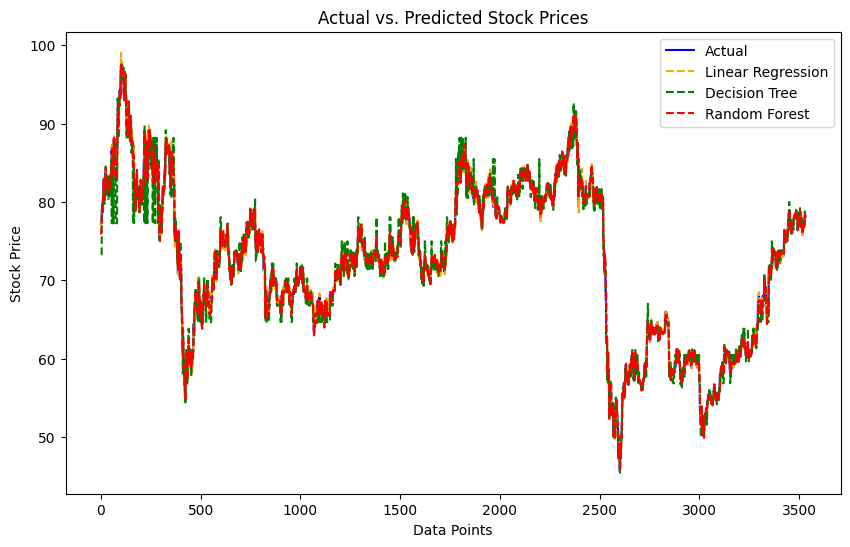

In [133]:
# Plot actual vs. predicted values for comparison
plt.figure(figsize=(10, 6))
plt.plot(y_test.ravel(), label='Actual', color='blue')
plt.plot(linear_preds.ravel(), label='Linear Regression', linestyle='--', color='orange')
plt.plot(tree_preds.ravel(), label='Decision Tree', linestyle='--', color='green')
plt.plot(forest_preds.ravel(), label='Random Forest', linestyle='--', color='red')
plt.legend()
plt.xlabel('Data Points')
plt.ylabel('Stock Price')
plt.title('Actual vs. Predicted Stock Prices')
plt.show()


# D. Build model deep learning

### 1. Prepare training and testing data

In [9]:
data_FPT = TrainingDataset(df_FPT)
data_MSN = TrainingDataset(df_MSN)
data_VIC = TrainingDataset(df_VIC)
data_PNJ = TrainingDataset(df_PNJ)
# Combine training datasets into one
train_datasets = ConcatDataset([data_FPT, data_MSN, data_VIC])

# Create DataLoader for training datasets
train_loader = DataLoader(train_datasets, batch_size=BATCH_SIZE, shuffle=True)

# Create DataLoader for the test dataset
test_loader = DataLoader(data_PNJ, batch_size=BATCH_SIZE, shuffle=False)

### 2. Neural Network

In [11]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(NeuralNetwork, self).__init__()

        # Define the first hidden layer
        self.fc1 = nn.Linear(input_dim, 256)
        self.relu = nn.ReLU()

        # Define the second hidden layer
        self.fc2 = nn.Linear(256, 64)
        
        # Define the third hidden layer
        self.fc3 = nn.Linear(64, 16)

        # Define the output layer
        self.fc4 = nn.Linear(16, output_dim)

    def forward(self, x):
        # Fully connected layer 1
        x = self.fc1(x)
        x = self.relu(x)

        # Fully connected layer 2
        x = self.fc2(x)
        x = self.relu(x)

        # Fully connected layer 3
        x = self.fc3(x)
        x = self.relu(x)

        # Output layer
        x = self.fc4(x)
        return x

In [10]:
# Create an instance of the model
model_nn = NeuralNetwork(input_dim=INPUT_DIM, output_dim=OUTPUT_DIM)

# Move the model to the specified device (cuda or cpu)
model_nn = model_nn.to(DEVICE)

# Criterion (Loss function)
criterion = nn.MSELoss(reduction='mean')

# Optimizer
optimizer = optim.Adam(model_nn.parameters(), lr=LEARNING_RATE)

In [11]:

# Training loop
start_time = time.time()

loss_model_nn_values = []

for epoch in range(EPOCHS):
    total_loss = 0.0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{EPOCHS}", leave=True)

    for input_batch, target_batch in progress_bar:
        # Move input and target data to the specified device
        input_batch, target_batch = input_batch.to(DEVICE), target_batch.to(DEVICE)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        output = model_nn(input_batch.float())

        # Calculate loss
        loss = criterion(output, target_batch.float())

        # Backward pass
        loss.backward()

        # Update weights
        optimizer.step()

        total_loss += loss.item()

        progress_bar.set_postfix({"Average Loss:": total_loss / len(train_loader),"Total Loss:": total_loss })

    loss_model_nn_values.append(total_loss)
    
    if (epoch + 1) % 10 == 0:
        # print(f"Epoch {epoch + 1}, Average Loss: {total_loss / len(train_loader)}")
        torch.save(model_nn.state_dict(), "results/model_nn.pth")

training_time = time.time() - start_time
print("Training time: {:.2f} seconds".format(training_time))

Epoch 1/100:   0%|          | 0/71 [00:00<?, ?it/s]c:\Users\ADMIN\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([128, 1])) that is different to the input size (torch.Size([128, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 1/100:  99%|█████████▊| 70/71 [00:06<00:00,  8.89it/s, Average Loss:=4.87e+4, Total Loss:=3.46e+6]c:\Users\ADMIN\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 100/100: 100%|██████████| 71/71 [00:05<00:00, 12.68it/s, Average Loss:=

Training time: 662.28 seconds


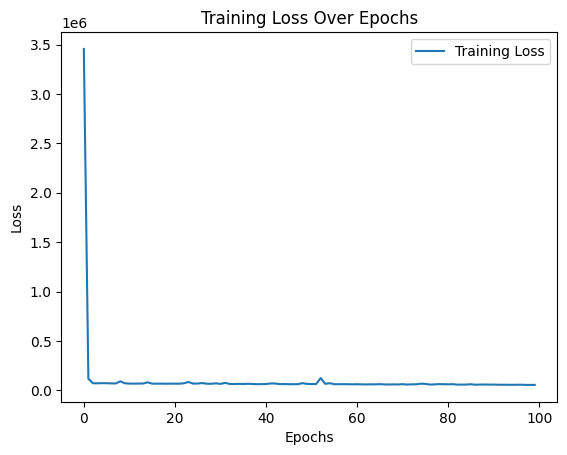

In [12]:
import matplotlib.pyplot as plt

# Plotting the loss curve
plt.plot(loss_model_nn_values, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

### 3.RNN

In [48]:
class RNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, device):
        super(RNN, self).__init__()
        # Hidden dimension
        self.hidden_dim = hidden_dim
        
        self.device = device

        # Number of hidden layers
        self.layer_dim = num_layers

        # Recurrent layer
        self.rnn = nn.RNN(input_dim, hidden_dim, num_layers, batch_first=True, nonlinearity='relu').to(self.device)

        # Output layer
        self.fc = nn.Linear(hidden_dim, output_dim).to(self.device)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(self.device)

        # Forward propagate RNN
        out, hn = self.rnn(x, h0.detach())

        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])

        return out

In [14]:
model_rnn = RNN(input_dim=INPUT_DIM, hidden_dim=HIDDEN_DIM, output_dim=OUTPUT_DIM , num_layers=NUM_LAYERS, device=DEVICE)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model_rnn.parameters(), lr=0.02)

In [15]:
# Training loop
start_time = time.time()

loss_model_rnn_values = []

for epoch in range(EPOCHS):
    total_loss = 0.0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{EPOCHS}", leave=True)

    for x_batch, y_batch in progress_bar:
        y_train_pred = model_rnn(x_batch.float())
        loss = criterion(y_train_pred, y_batch.float())
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
        total_loss += loss.item()

        progress_bar.set_postfix({"Loss": total_loss / len(train_loader)})

    loss_model_rnn_values.append(total_loss)
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch + 1}, Average Loss: {total_loss / len(train_loader)}")
        torch.save(model_rnn, "results/model_rnn.pt")

training_time = time.time() - start_time
print("Training time: {:.2f} seconds".format(training_time))


Epoch 10/100: 100%|██████████| 71/71 [00:05<00:00, 12.83it/s, Loss=5.48]


Epoch 10, Average Loss: 5.47959608091435


Epoch 20/100: 100%|██████████| 71/71 [00:05<00:00, 12.85it/s, Loss=2.22] 


Epoch 20, Average Loss: 2.218884740916776


Epoch 30/100: 100%|██████████| 71/71 [00:05<00:00, 11.90it/s, Loss=3.59] 


Epoch 30, Average Loss: 3.5883356920430356


Epoch 40/100: 100%|██████████| 71/71 [00:06<00:00, 10.83it/s, Loss=5.3] 


Epoch 40, Average Loss: 5.300883200806632


Epoch 50/100: 100%|██████████| 71/71 [00:06<00:00, 11.39it/s, Loss=2.6]  


Epoch 50, Average Loss: 2.6011748078843238


Epoch 60/100: 100%|██████████| 71/71 [00:05<00:00, 11.87it/s, Loss=3.46] 


Epoch 60, Average Loss: 3.459998621067531


Epoch 70/100: 100%|██████████| 71/71 [00:05<00:00, 12.11it/s, Loss=693] 


Epoch 70, Average Loss: 692.5415008974747


Epoch 80/100: 100%|██████████| 71/71 [00:05<00:00, 12.39it/s, Loss=696] 


Epoch 80, Average Loss: 696.0465483329665


Epoch 90/100: 100%|██████████| 71/71 [00:05<00:00, 12.17it/s, Loss=697] 


Epoch 90, Average Loss: 697.376826756437


Epoch 100/100: 100%|██████████| 71/71 [00:05<00:00, 12.41it/s, Loss=685] 


Epoch 100, Average Loss: 684.5241187995588
Training time: 596.64 seconds


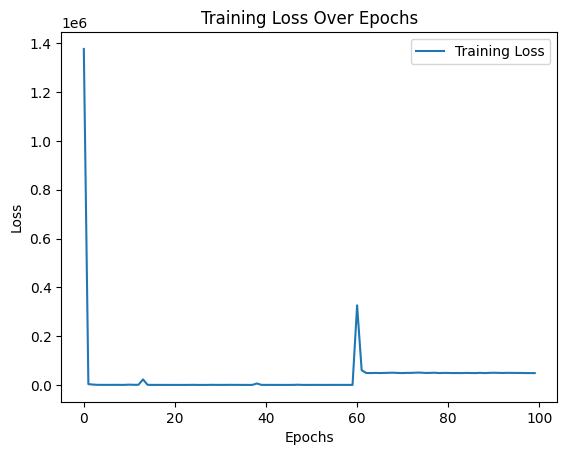

In [16]:
import matplotlib.pyplot as plt

# Plotting the loss curve
plt.plot(loss_model_rnn_values, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()


### 4. LSTM

In [62]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, device):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.device = device
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True).to(self.device)
        self.fc = nn.Linear(hidden_dim, output_dim).to(self.device)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(self.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(self.device)
        out, (hn, cn) = self.lstm(x.to(self.device), (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [18]:
model_LSTM = LSTM(input_dim=INPUT_DIM, hidden_dim=HIDDEN_DIM, output_dim=OUTPUT_DIM, num_layers=NUM_LAYERS, device=DEVICE)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model_LSTM.parameters(), lr=0.02)

In [19]:
# Training loop
start_time = time.time()

loss_model_LSTM_values = []

for epoch in range(EPOCHS):
    total_loss = 0.0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{EPOCHS}", leave=True)

    for x_batch, y_batch in progress_bar:
        y_train_pred = model_LSTM(x_batch.float())
        loss = criterion(y_train_pred, y_batch.float())
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
        total_loss += loss.item()

        progress_bar.set_postfix({"Loss": total_loss / len(train_loader)})

    loss_model_LSTM_values.append(total_loss)
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch + 1}, Average Loss: {total_loss / len(train_loader)}")
        torch.save(model_LSTM, "results/model_lstm.pt")

training_time = time.time() - start_time
print("Training time: {:.2f} seconds".format(training_time))

Epoch 10/100: 100%|██████████| 71/71 [00:05<00:00, 12.42it/s, Loss=688] 


Epoch 10, Average Loss: 688.2827700762682


Epoch 20/100: 100%|██████████| 71/71 [00:05<00:00, 12.31it/s, Loss=691] 


Epoch 20, Average Loss: 690.769735846721


Epoch 30/100: 100%|██████████| 71/71 [00:05<00:00, 12.42it/s, Loss=692] 


Epoch 30, Average Loss: 692.3106104891065


Epoch 40/100: 100%|██████████| 71/71 [00:05<00:00, 12.31it/s, Loss=705] 


Epoch 40, Average Loss: 704.7523906868948


Epoch 50/100: 100%|██████████| 71/71 [00:05<00:00, 12.60it/s, Loss=691] 


Epoch 50, Average Loss: 690.6832679426167


Epoch 60/100: 100%|██████████| 71/71 [00:05<00:00, 12.53it/s, Loss=688]


Epoch 60, Average Loss: 687.8603534967127


Epoch 70/100: 100%|██████████| 71/71 [00:05<00:00, 12.16it/s, Loss=694]


Epoch 70, Average Loss: 694.4514968227332


Epoch 80/100: 100%|██████████| 71/71 [00:05<00:00, 12.42it/s, Loss=707]


Epoch 80, Average Loss: 707.1465282171545


Epoch 90/100: 100%|██████████| 71/71 [00:05<00:00, 12.60it/s, Loss=695]


Epoch 90, Average Loss: 694.950478997029


Epoch 100/100: 100%|██████████| 71/71 [00:05<00:00, 12.24it/s, Loss=690] 

Epoch 100, Average Loss: 690.1675412889937
Training time: 580.20 seconds


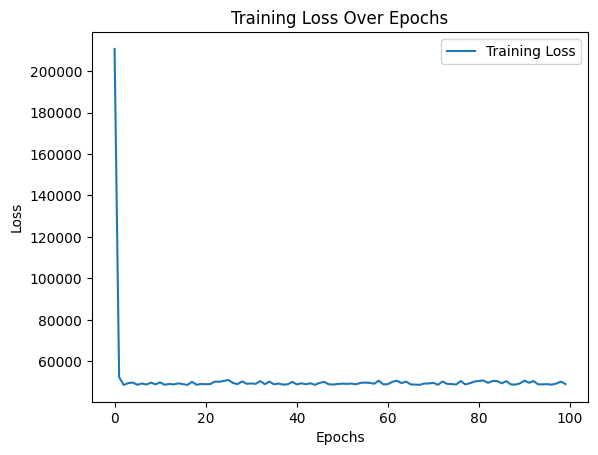

In [20]:
import matplotlib.pyplot as plt

# Plotting the loss curve
plt.plot(loss_model_LSTM_values, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

### 5. Transformer

In [72]:
D_MODEL = 256
NHEAD = 8
DROPOUT= 0.2

In [73]:
class StockPriceTransformer(nn.Module):
    def __init__(self, input_dim,  d_model, nhead, num_layers, dropout, output_dim):
        super(StockPriceTransformer, self).__init__()
        self.input_linear_en = nn.Linear(input_dim, d_model)
        self.input_linear_de = nn.Linear(1, d_model)
        self.transformer = nn.Transformer(d_model, nhead, num_layers, dropout=dropout)
        self.output_linear = nn.Linear(d_model, output_dim)

    def forward(self, src, tgt):
        src = self.input_linear_en(src)
        tgt = self.input_linear_de(tgt)
        output = self.transformer(src, tgt)
        output = self.output_linear(output)
        return output

model_transformer = StockPriceTransformer(input_dim=INPUT_DIM, output_dim=OUTPUT_DIM,d_model=D_MODEL, nhead=NHEAD, num_layers=NUM_LAYERS, dropout=DROPOUT)
criterion = nn.MSELoss()
optimizer = optim.Adam(model_transformer.parameters(), lr=LEARNING_RATE)

c:\Users\ADMIN\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [11]:
# Training loop
start_time = time.time()
loss_model_transformer_LSTM_values = []

for epoch in range(EPOCHS):
    total_loss = 0.0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{EPOCHS}", leave=True)

    for src_batch, tgt_batch in progress_bar:
        optimizer.zero_grad()
        # print(src_batch.shape, tgt_batch.unsqueeze(dim=1).shape)
        output = model_transformer(src_batch.float(), tgt_batch.unsqueeze(dim=1).float())
        
        loss = criterion(output, tgt_batch.float())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        progress_bar.set_postfix({"Loss": total_loss / len(train_loader)})
        
    loss_model_transformer_LSTM_values.append(total_loss)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch + 1}, Average Loss: {total_loss / len(train_loader)}")
        torch.save(model_transformer, "results/model_transformer.pt")

Epoch 1/100:   0%|          | 0/71 [00:00<?, ?it/s]c:\Users\ADMIN\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([128, 1])) that is different to the input size (torch.Size([128, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 1/100:  99%|█████████▊| 70/71 [00:35<00:00,  1.88it/s, Loss=1.17e+3]c:\Users\ADMIN\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 10/100: 100%|██████████| 71/71 [00:46<00:00,  1.52it/s, Loss=722]


Epoch 10, Average Loss: 722.4715378452355


Epoch 14/100:  30%|██▉       | 21/71 [00:12<00:30,  1.65it/s, Loss=223]


KeyboardInterrupt: 

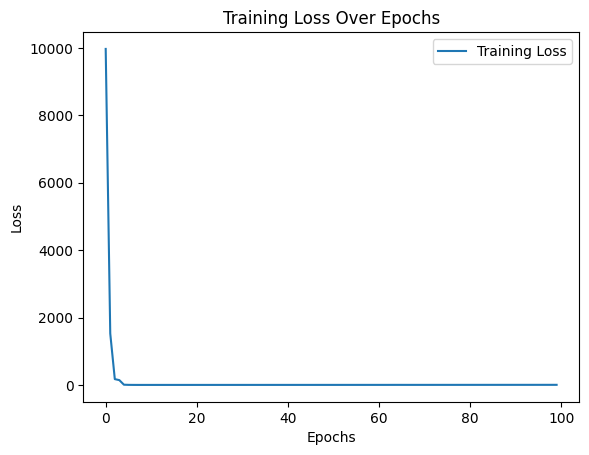

In [ ]:
import matplotlib.pyplot as plt

# Plotting the loss curve
plt.plot(loss_model_transformer_LSTM_values, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

# E. Load model and prediction

In [121]:
def predict(model, dataloader):
    predictions = []
    # Iterate through the test DataLoader
    for input_batch, target_batch in dataloader:
        input_batch = input_batch.to(DEVICE)
        output = model(input_batch.float())
        output = output.view(-1).detach().numpy()
        predictions.append(output)
    
    # Concatenate predictions into a single numpy array
    predictions = np.concatenate(predictions, axis=0)
    
    return predictions

def predict_transfomer(model, dataloader):
    predictions = []
    # Iterate through the test DataLoader
    for input_batch, _ in dataloader:
        input_batch = input_batch.to(DEVICE)
        target_batch = torch.zeros(input_batch.shape[0], 1, 1)
        output = model(input_batch.float(), target_batch.float())
        output = output.view(-1).detach().numpy()
        predictions.append(output)
    
    # Concatenate predictions into a single numpy array
    predictions = np.concatenate(predictions, axis=0)
    
    return predictions

def labels_data(test_loader):
    y_test_list = []

    for _, target_batch in test_loader:
        y_test = target_batch.view(-1).detach().numpy()
        
        y_test_list.append(y_test)

    # Concatenate the list of numpy arrays into a single numpy array
    y_real = np.concatenate(y_test_list, axis=0)
    return y_real

In [127]:
# load model Neural network
model_nn = NeuralNetwork(input_dim=INPUT_DIM, output_dim=OUTPUT_DIM)
# Load the pre-trained weights
model_nn.load_state_dict(torch.load("results/model_nn.pth"))
# Put the model in evaluation mode
model_nn.eval()
# # Use the predict function to get predictions on the test data
nn_pred_values = predict(model_nn, test_loader)


In [128]:
# load model RNN
model_rnn = RNN(input_dim=INPUT_DIM, hidden_dim=HIDDEN_DIM, output_dim=OUTPUT_DIM, num_layers=NUM_LAYERS, device=DEVICE)

# Load the entire model
model_rnn = torch.load("results/model_rnn.pt", map_location=DEVICE)

# Put the model in evaluation mode
model_rnn.eval()

# Use the predict function to get predictions on the test data
rnn_pred_values = predict(model_rnn, test_loader)

In [129]:
# load model lstm
model_lstm = LSTM(input_dim=INPUT_DIM, hidden_dim=HIDDEN_DIM, output_dim=OUTPUT_DIM, num_layers=NUM_LAYERS, device=DEVICE)

# Load the entire model
model_lstm = torch.load("results/model_lstm.pt", map_location=DEVICE)

# Put the model in evaluation mode
model_lstm.eval()

# Use the predict function to get predictions on the test data
lstm_pred_values = predict(model_lstm, test_loader)

In [123]:
# load transformer model
model_transformer = StockPriceTransformer(input_dim=INPUT_DIM, output_dim=OUTPUT_DIM,d_model=D_MODEL, nhead=NHEAD, num_layers=NUM_LAYERS, dropout=DROPOUT)
model_transformer = torch.load("results/model_transformer.pt", map_location=DEVICE)
model_transformer.eval()
transformer_pred_values = predict_transfomer(model_transformer, test_loader)

In [135]:
# Load model
linear_model = joblib.load(f'{MODEL_DIR}linear_model.joblib')
tree_model = joblib.load(f'{MODEL_DIR}tree_model.joblib')
forest_model = joblib.load(f'{MODEL_DIR}forest_model.joblib')

linear_preds = linear_model.predict(X_test)
tree_preds = tree_model.predict(X_test)
forest_preds = forest_model.predict(X_test)

In [142]:
y_real = labels_data(test_loader)
linear_mse = mean_squared_error(y_test, linear_preds)
tree_mse = mean_squared_error(y_test, tree_preds)
forest_mse = mean_squared_error(y_test, forest_preds)
mse_nn = mean_squared_error(y_real, nn_pred_values)
mse_rnn = mean_squared_error(y_real, rnn_pred_values)
mse_lstm = mean_squared_error(y_real, lstm_pred_values)
mse_transformer = mean_squared_error(y_real, transformer_pred_values)

data = {
    'Model': ['Linear Regression', 'Decision Tree', 'Random Forest', 'Neural Network', 'RNN', 'LSTM', 'Transformer'],
    'MSE': [linear_mse, tree_mse, forest_mse, mse_nn, mse_rnn, mse_lstm, mse_transformer]
}
df_mse = pd.DataFrame(data)
df_mse

,Model,MSE
0,Linear Regression,0.432483
1,Decision Tree,2.103156
2,Random Forest,0.549208
3,Neural Network,218.843267
4,RNN,113.197537
5,LSTM,107.986692
6,Transformer,136.871450


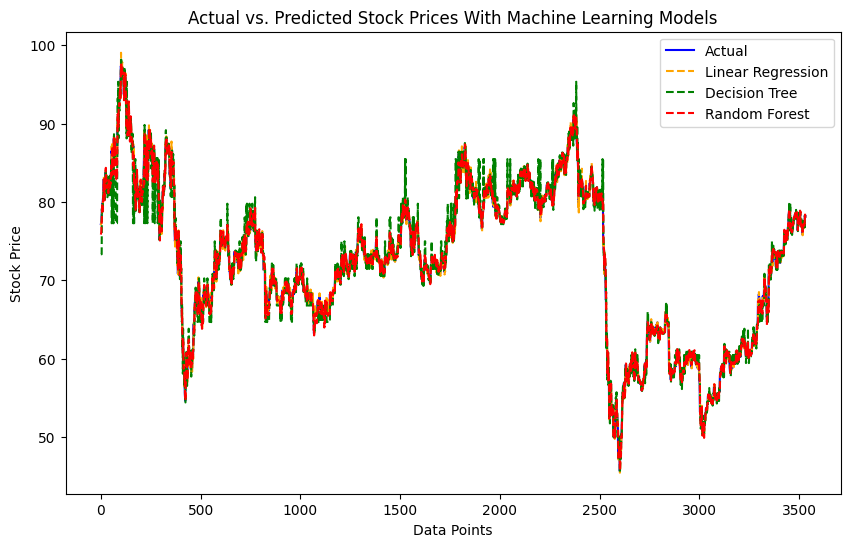

In [145]:
# Plot actual vs. predicted values for comparison
plt.figure(figsize=(10, 6))
plt.plot(y_test.ravel(), label='Actual', color='blue')
plt.plot(linear_preds.ravel(), label='Linear Regression', linestyle='--', color='orange')
plt.plot(tree_preds.ravel(), label='Decision Tree', linestyle='--', color='green')
plt.plot(forest_preds.ravel(), label='Random Forest', linestyle='--', color='red')
plt.legend()
plt.xlabel('Data Points')
plt.ylabel('Stock Price')
plt.title('Actual vs. Predicted Stock Prices With Machine Learning Models')
plt.show()

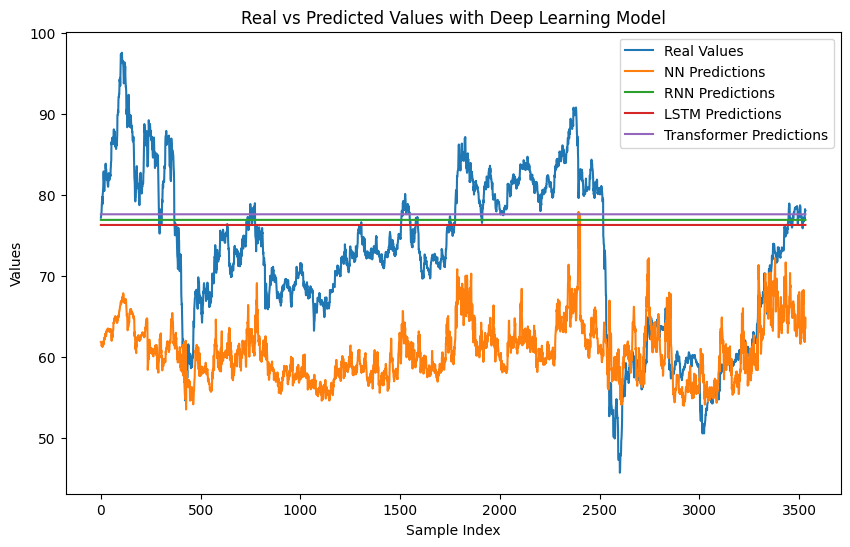

In [147]:
# Vẽ biểu đồ line cho tất cả các thuộc tính
plt.figure(figsize=(10, 6))
plt.plot(y_real[10:], label='Real Values', linestyle='-', markersize=2)
plt.plot(nn_pred_values[10:], label='NN Predictions', linestyle='-', markersize=2)
plt.plot(rnn_pred_values[10:], label='RNN Predictions', linestyle='-', markersize=2)
plt.plot(lstm_pred_values[10:], label='LSTM Predictions', linestyle='-', markersize=2)
plt.plot(transformer_pred_values[10:], label='Transformer Predictions', linestyle='-', markersize=2)

plt.xlabel('Sample Index')
plt.ylabel('Values')
plt.title('Real vs Predicted Values with Deep Learning Model')
plt.legend()
plt.show()

# F. Compute Volatility